In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from tqdm.notebook import trange, tqdm
from sklearn import cluster
from sklearn import metrics
from sklearn import manifold
from sklearn import decomposition
import time
import requests
import zipfile
import io
import os
import subprocess
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split
from sklearn import pipeline as pip
import logging
import pickle
import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, precision_score, recall_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
from urllib.parse import urlparse
import pkg_resources
from flask import Flask, request, jsonify


## Objectif : Construire un modèle qui détectera efficacement les clients susceptibles d'être en défaut de paiement (classe "positive")
- Classe 0 : Clients qui ne seront pas en défaut de paiement
- Classe 1 : Clients en défaut de paiement

FN - mauvais client prédit bon client : donc crédit accordé et perte en capital => Le plus 'dangereux'

FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge

In [2]:
def custom_score(y_test, y_pred, **kwargs):
    '''
    Score métier basé sur la matrice de confusion - les faux négatifs pénalisent le score
    10 fois plus que les faux positifs
    '''
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total = (tn + tp + fn + fp)
    score = (10*fn + fp)/total
    return score

def custom_score_reg(y_test, y_pred,**kwargs):
    y_pred=classify(y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total = (tn + tp + fn + fp)
    score = (10*fn + fp)/total
    return score

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

def classify(y_pred, seuil=0.7):
    clf=[]
    for val in y_pred:
        if val>=seuil: val=1
        else: val=0
        clf.append(val)
    return np.array(clf)

In [3]:
data=pd.read_csv("final_data/df_train.csv", sep=',').drop(columns='Unnamed: 0')

X=data.drop(columns='TARGET')
colmn=X.columns

scaler = RobustScaler()

X = scaler.fit_transform(X.values)
X = pd.DataFrame(X, columns=colmn)

y=data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(45226, 10)
(11307, 10)


# Valeurs de références

### Évaluation des valeurs min / max du score métier :

<Axes: >

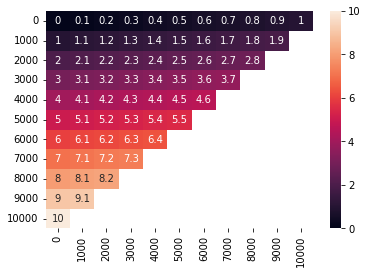

In [4]:
total = 10000
fn=np.arange(0,11000,1000)
fp=np.arange(0,11000,1000)

n_list=[]
for n in fn:
    p_list=[]
    for p in fp:
        if n+p>10000:
            continue
        else:
            p_list.append((10*n + p)/total)
    n_list.append(p_list)

df = pd.DataFrame(n_list, index=fn, columns=fp)
sns.heatmap(df, annot=True)

### Dummy models : Références pour évaluer la performance des modèles 'réels'

Score métier : Une valeur de 5 correspond à une classification aléatoire.  Un score plus élevé signifie un résultat plus mauvais que l'aléatoire

Régression : Un RMSE aux alentours de 0.5 correspond à une classification aléatoire. Un score plus élevé signifie un résultat plus mauvais que l'aléatoire

In [5]:
from sklearn.dummy import DummyRegressor

Dregr = DummyRegressor(strategy='mean')

Dregr.fit(X_train, y_train)

y_pred = Dregr.predict(X_test)

(rmse, mae, r2) = eval_metrics(y_test, y_pred)
print("rmse:", rmse)
print("mae:", rmse)
print("r2:",r2)
print("Score métier:", custom_score_reg(y_test,y_pred))

rmse: 0.5000204779882595
mae: 0.5000204779882595
r2: -0.00022875407315847696
Score métier: 4.939418059609092


Classification : L'AUC est à 0.5 pour une classification aléatoire. On veut s'éloigner le plus possible de cette valeur (0 = classification "inverse", il suffit d'inverser les résultats. 1 = classification parfaite.)

In [6]:
from sklearn.dummy import DummyClassifier

Dclf = DummyClassifier(strategy='most_frequent')

Dclf.fit(X_train, y_train)

y_pred = Dclf.predict(X_test)

print("AUC:", roc_auc_score(y_test, y_pred))
print("Score métier:", custom_score(y_test,y_pred))


AUC: 0.5
Score métier: 0.5060581940390908


# Tests de modèles

Modèles testés:
- Random Forest
- K-neighbors
- SGD
- Régression logistique
- Elastic Net
- Régression linéaire

### Préparation des dictionnaires de paramètres

In [7]:
RF_params = {
    'n_estimators': [1, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [50, 100, 200]
}

KN_params = {
    'n_neighbors': [5, 20, 50],
    'weights': ['uniform', 'distance'],
    'leaf_size': [
        10,
        30,
        50,
    ]
}

SGD_params = {
    'loss': ['log_loss', 'squared_hinge', 'squared_error'],
    'penalty': ['l2', 'l1', 'elasticnet', None],
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

LR_params = {
    'C': np.logspace(-3, 3, 7),
    'solver': ['saga', 'liblinear'],
}

EN_param = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.2, 0.5, 0.8],
    'max_iter': [500, 1000, 2000],
}

LinR_param = {}

In [8]:
clfs = {
    "C_sgd": [SGDClassifier(), SGD_params],
    "C_kn": [KNeighborsClassifier(), KN_params],
    "C_lr": [LogisticRegression(), LR_params],
    "C_rf": [RandomForestClassifier(), RF_params],
    "R_en": [ElasticNet(), EN_param],
    "R_linR":[LinearRegression(), LinR_param]
}

In [9]:
from datetime import datetime 
xp = datetime.now().strftime("%d/%m/%Y %H:%M")
xp

'04/10/2023 21:57'

### Entraînement des modèles et enregistrement des métriques, stockage des modèles / artéfacts avec MlFlow

In [10]:
# Préparation des scorers
custom_scorer = make_scorer(custom_score, greater_is_better=False)
roc_score = make_scorer(roc_auc_score)
custom_scorer_reg = make_scorer(custom_score_reg, greater_is_better=False)


for key in clfs.keys():
    
    mlflow.runName=key
    
    model = clfs[key][0]
    params = clfs[key][1]
        
    print("ALGO. EN COURS:",key)

    with mlflow.start_run() as run:
    
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)

        mlflow.sklearn.autolog()

        # Modèles de classification - entrainement
        if key[0]=="C":
            randCV = RandomizedSearchCV(estimator = model,
                                   param_distributions = params,
                                   cv=5,
                                   random_state=123,
                                   scoring={"Score métier":custom_scorer, "AUC":roc_score}, 
                                   refit="Score métier")
            
            
            mdl_fit=randCV.fit(X_train, y_train)
            
            mean_score = randCV.best_score_ 
            
            y_pred = mdl_fit.best_estimator_.predict(X_test)
            
        
        # Modèles de régression - entrainement    
        if key[0]=="R":
            randCV = RandomizedSearchCV(estimator = model,
                                   param_distributions = params,
                                   cv=5,
                                   random_state=123,
                                   scoring=custom_scorer_reg,
                                   refit="Score métier")
            mdl_fit=randCV.fit(X_train, y_train)
            
            mean_score = randCV.best_score_
            
            y_pred = classify(mdl_fit.best_estimator_.predict(X_test))

        # Enregistrement de la signature et log des paramètres
        signature = infer_signature(X_test, y_pred)
        mlflow.log_params(params)

        # Enregistrement des métriques classification
        if key[0]=="C":
            mlflow.log_metrics({"AUC": roc_auc_score(y_test, y_pred)})
            print("AUC:",roc_auc_score(y_test, y_pred))
            mlflow.log_metric("means score métier", mean_score)

        # Enregistrement des métriques régression
        if key[0]=="R":
            (rmse, mae, r2) = eval_metrics(y_test, y_pred)
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("means score métier", mean_score)
            print("RMSE:",rmse)
            print("r2",r2)

        mlflow.log_metrics({"score metier": custom_score(y_test, y_pred)})

        print("score metier :", custom_score(y_test, y_pred))

        # Sauvegarde du modèle
        mlflow.sklearn.log_model(
                sk_model=mdl_fit.best_estimator_,
                artifact_path="sklearn-artifacts",
                signature=signature,
                registered_model_name="sk-learn-"+key+"-model",
            )

print("Fin")

ALGO. EN COURS: C_sgd


2023/10/04 21:58:00 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/04 21:58:02 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/04 21:58:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/camille/.local/lib/python3.10/site-packages/mlflow/sklearn/utils.py:784: UserWarning: Top 5 child runs will be created based on ordering in rank_test_S

AUC: 0.6889455859477798
score metier : 1.696824975678783


2023/10/04 21:58:04 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Registered model 'sk-learn-C_sgd-model' already exists. Creating a new version of this model...
2023/10/04 21:58:04 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-C_sgd-model, version 15
Created version '15' of model 'sk-learn-C_sgd-model'.


ALGO. EN COURS: C_kn


2023/10/04 22:01:35 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/04 22:01:37 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/04 22:01:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/camille/.local/lib/python3.10/site-packages/mlflow/sklearn/utils.py:784: UserWarning: Top 5 child runs will be created based on ordering in rank_test_S

AUC: 0.7072013591856902
score metier : 1.5838860882639074


2023/10/04 22:01:43 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Registered model 'sk-learn-C_kn-model' already exists. Creating a new version of this model...
2023/10/04 22:01:43 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-C_kn-model, version 9
Created version '9' of model 'sk-learn-C_kn-model'.


ALGO. EN COURS: C_lr


2023/10/04 22:01:53 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/04 22:01:54 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/04 22:01:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/camille/.local/lib/python3.10/site-packages/mlflow/sklearn/utils.py:784: UserWarning: Top 5 child runs will be created based on ordering in rank_test_S

AUC: 0.6858341284029318
score metier : 1.6872733704784646


2023/10/04 22:01:56 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Registered model 'sk-learn-C_lr-model' already exists. Creating a new version of this model...
2023/10/04 22:01:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-C_lr-model, version 17
Created version '17' of model 'sk-learn-C_lr-model'.


ALGO. EN COURS: C_rf


2023/10/04 22:10:59 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/04 22:11:01 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/04 22:11:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/camille/.local/lib/python3.10/site-packages/mlflow/sklearn/utils.py:784: UserWarning: Top 5 child runs will be created based on ordering in rank_test_S

AUC: 0.7338217287592814
score metier : 1.503758733527903


2023/10/04 22:11:03 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Registered model 'sk-learn-C_rf-model' already exists. Creating a new version of this model...
2023/10/04 22:11:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-C_rf-model, version 9
Created version '9' of model 'sk-learn-C_rf-model'.


ALGO. EN COURS: R_en


2023/10/04 22:11:08 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/04 22:11:09 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/04 22:11:09 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


RMSE: 0.6877363877195563
r2 -0.8922031443763987
score metier : 4.686035199433979


2023/10/04 22:11:11 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Registered model 'sk-learn-R_en-model' already exists. Creating a new version of this model...
2023/10/04 22:11:11 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-R_en-model, version 10
Created version '10' of model 'sk-learn-R_en-model'.
/home/camille/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


ALGO. EN COURS: R_linR


2023/10/04 22:11:13 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/04 22:11:14 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/10/04 22:11:14 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


RMSE: 0.6140940675782438
r2 -0.5086675780891856
score metier : 3.4455646944370746


2023/10/04 22:11:16 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Registered model 'sk-learn-R_linR-model' already exists. Creating a new version of this model...
2023/10/04 22:11:16 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-R_linR-model, version 10


Fin


Created version '10' of model 'sk-learn-R_linR-model'.


In [11]:
# Interface MlFlow - contrôle des modèles
!mlflow ui --port 8080

[2023-10-04 22:11:17 +0200] [600007] [INFO] Starting gunicorn 20.1.0
[2023-10-04 22:11:17 +0200] [600007] [INFO] Listening at: http://127.0.0.1:8080 (600007)
[2023-10-04 22:11:17 +0200] [600007] [INFO] Using worker: sync
[2023-10-04 22:11:17 +0200] [600008] [INFO] Booting worker with pid: 600008
[2023-10-04 22:11:17 +0200] [600009] [INFO] Booting worker with pid: 600009
[2023-10-04 22:11:17 +0200] [600010] [INFO] Booting worker with pid: 600010
[2023-10-04 22:11:17 +0200] [600011] [INFO] Booting worker with pid: 600011
^C
[2023-10-04 22:18:32 +0200] [600007] [INFO] Handling signal: int
[2023-10-04 22:18:32 +0200] [600009] [INFO] Worker exiting (pid: 600009)
[2023-10-04 22:18:32 +0200] [600010] [INFO] Worker exiting (pid: 600010)
[2023-10-04 22:18:32 +0200] [600008] [INFO] Worker exiting (pid: 600008)
[2023-10-04 22:18:32 +0200] [600011] [INFO] Worker exiting (pid: 600011)


In [ ]:
logged_model = 'runs:/89a4e91d22d44bba98b32d99bb28c3f5/sklearn-artifacts' # Modèle de régression logistique 
loaded_model = mlflow.sklearn.load_model(logged_model)

y_pred=loaded_model.predict_proba(X_test)
# test sur données normalisées

preds=[]

# histogramme pour vérifier la répartition du résultat des prédictions
for a in y_pred:
    preds.append(a[0])
b=plt.hist(preds,bins=100, log=True)
plt.show()

## Feature importance :

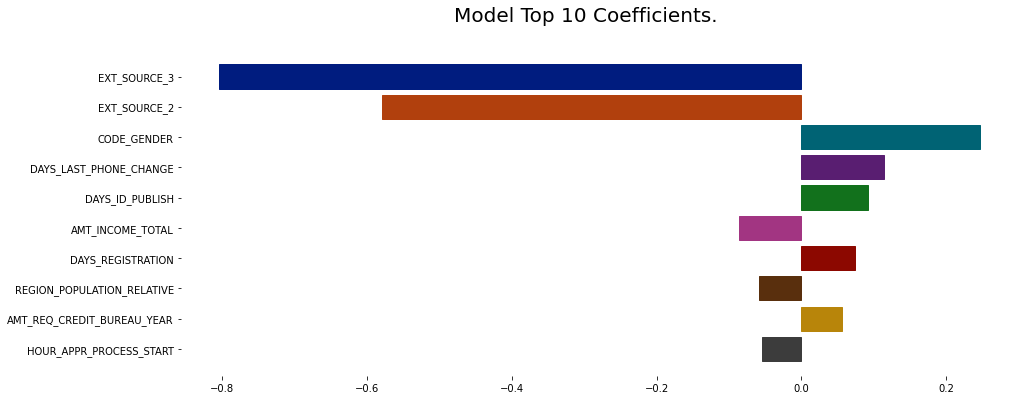

In [14]:
# Feature importance du modèle
plt.figure(figsize=(15,6))
Modelcoeff = loaded_model.coef_
color_list =  sns.color_palette("dark", len(X_test.columns)) 
top_x = 10
Modelcoeff = loaded_model.coef_[0]
idx = np.argsort(np.abs(Modelcoeff))[::-1] 
lreg_ax = plt.barh(X_test.columns[idx[:top_x]][::-1], Modelcoeff[idx[:top_x]][::-1])
for i,bar in enumerate(lreg_ax):
    bar.set_color(color_list[idx[:top_x][::-1][i]])
    plt.box(False) 
lr_title = plt.suptitle("Model Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")

In [15]:
loaded_model.coef_

array([[-0.80469235, -0.57909673,  0.09198022,  0.07401192,  0.11428749,
        -0.05848817, -0.08564495, -0.05495687,  0.05545084,  0.24638322]])

In [16]:
import numpy
import scipy
print("NumPy version:", numpy.__version__)
print("SciPy version:", scipy.__version__)

NumPy version: 1.23.4
SciPy version: 1.9.3


In [17]:
# Feature importance locale
import shap

bg_data = shap.sample(X_train, 1000, random_state=123)

explainer = shap.KernelExplainer(loaded_model.predict_proba, data=bg_data)
shap_values = explainer.shap_values(X_test.sample(100))

/home/camille/.local/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/camille/.local/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max

  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

In [18]:
explainer = shap.Explainer(loaded_model, bg_data)
shap_values2 = explainer(X_test.sample(100))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


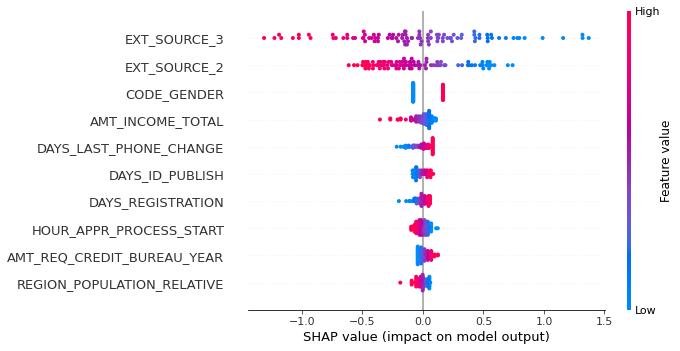

In [19]:
shap.plots.beeswarm(shap_values2)

In [20]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[1][1], X_train.iloc[0], feature_names=X_train.columns)

IndexError: invalid index to scalar variable.

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[0][1], X_test.iloc[0], feature_names=X_train.columns)

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, max_display=10)

In [ ]:
test = pip.Pipeline([('scaler', scaler),
                        ('clf', loaded_model)])
test.predict(X_train.sample(10))

In [ ]:
ppl = pip.Pipeline([('scaler', scaler),
                        ('clf', loaded_model)])

### test avec données d'entrainement
Pour vérifier qu'on a bien des résultats similaires (AUC et score métier) et que le pipeline fonctionne correctement (scaling puis prédiction)

In [ ]:
data=pd.read_csv("final_data/df_train.csv", sep=',').drop(columns='Unnamed: 0')
test=data.drop(columns="TARGET")
testY=data["TARGET"]

print("AUC:",ppl.score(test, testY))
print("Custom score:",custom_score(ppl.predict(test), testY))

In [ ]:
if os.path.exists('pipeline')==False:
    os.makedirs('pipeline')

with open('pipeline/pipeline.pkl', 'wb') as file:
    pickle.dump(ppl, file)  

In [ ]:
mlflow.sklearn.save_model(ppl, 'pipeline', signature=signature)